In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
###EXECUTE ONLY IF YOU DO NOT HAVE DATA
'''
import os

i2m = list(zip(range(1,13), ['Gener','Febrer','Marc','Abril','Maig','Juny','Juliol','Agost','Setembre','Octubre','Novembre','Desembre']))
for year in range(2024, 2022, -1):
     for month, month_name in i2m:     
         if (month > 5) and (year>2023): continue 
         os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
         os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z' -o./data")
         os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
'''

'\nimport os\n\ni2m = list(zip(range(1,13), [\'Gener\',\'Febrer\',\'Marc\',\'Abril\',\'Maig\',\'Juny\',\'Juliol\',\'Agost\',\'Setembre\',\'Octubre\',\'Novembre\',\'Desembre\']))\nfor year in range(2024, 2022, -1):\n     for month, month_name in i2m:     \n         if (month > 5) and (year>2023): continue \n         os.system(f"wget \'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\'")\n         os.system(f"7z x \'{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\' -o./data")\n         os.system(f"rm \'{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\'")\n'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from sklearn.metrics import accuracy_score, confusion_matrix

#bikes data
folder_path = "data_no2020/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = [dd.read_csv(file, assume_missing=True, dtype={'last_reported': 'float64','station_id':'float64','num_docks_available':'float64','is_returning':'float64','ttl':'float64', 'status':'object'}) for file in csv_files]
df_datos_bikes = dd.concat(df_list, ignore_index=True)

#stations info + external sources
stations_info = pd.read_csv('stations_info/stations.csv')
calendar = pd.read_csv('calendar.csv')
metro = pd.read_csv('metro_bcn.csv')

In [4]:
from geopy.distance import geodesic

# Function to calculate the Haversine distance (in meters)
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters


stations_info['nearest_station_id'] = None
stations_info['nearest_station_distance'] = None
stations_info['stations_within_100m'] = None
stations_info['stations_within_300m'] = None
stations_info['stations_within_500m'] = None

# Iterate over each station to calculate distance to other station
for idx, station in stations_info.iterrows():
    nearest_station = None
    nearest_distance = float('inf')
    count_100m = 0
    count_300m = 0
    count_500m = 0
    
    for jdx, other_station in stations_info.iterrows():
        if station['station_id'] != other_station['station_id']:
            distance = haversine(station['lat'], station['lon'], 
                                 other_station['lat'], other_station['lon'])
            if distance < nearest_distance:
                nearest_station = other_station['station_id']
                nearest_distance = distance
            
            if distance <= 100:
                count_100m += 1
            if distance <= 300:
                count_300m += 1
            if distance <= 500:
                count_500m += 1
    
    # Add into Dataframe
    stations_info.at[idx, 'nearest_station_id'] = nearest_station
    stations_info.at[idx, 'nearest_station_distance'] = nearest_distance
    stations_info.at[idx, 'stations_within_100m'] = count_100m
    stations_info.at[idx, 'stations_within_300m'] = count_300m
    stations_info.at[idx, 'stations_within_500m'] = count_500m

stations_info

,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,...,short_name,nearby_distance,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,8013.0,46,...,1,1000.0,True,NaN,NaN,119,244.848175,0,4,10
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,8013.0,29,...,2,1000.0,True,NaN,NaN,387,130.33431,0,4,10
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,8013.0,27,...,3,1000.0,True,NaN,NaN,4,93.367414,1,2,12
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,8013.0,21,...,4,1000.0,True,NaN,NaN,3,93.367414,1,5,11
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...",8018.0,39,...,5,1000.0,True,NaN,NaN,418,6.943977,3,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,540,"C/ MANDONI, 6",ELECTRICBIKESTATION,41.369348,2.142601,18.0,"C/ MANDONI, 6",03-Sants-Montjuïc/14-la Font de la Guatlla,8004.0,20,...,521,1.0,True,NaN,NaN,182,238.165114,0,1,4
512,541,"C/ MARBRE, 2",ELECTRICBIKESTATION,41.361416,2.147617,28.0,"C/ MARBRE, 2",03-Sants-Montjuïc/13-la Marina de Port,8038.0,28,...,524,1000.0,True,NaN,NaN,537,438.069157,0,0,1
513,542,Copa América Barcelona - 542,VALET,41.374538,2.189217,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9000,1.0,True,NaN,False,31,39.112899,2,2,4
514,543,Copa América Barcelona - 543,VALET,41.383830,2.191371,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9001,1.0,True,NaN,False,116,8.784703,1,4,7


In [5]:
# Haversine formula to calculate the distance in meters
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of the Earth in meters (mean radius)
    R = 6371000
    distance = R * c
    return distance


# Function to find nearest metro station for each bicycle station
def find_nearest_metro(stations_info, metro):
    nearest_metro_ids = []
    nearest_distances = []

    for _, bike_station in stations_info.iterrows():
        bike_lat = bike_station['lat']
        bike_lon = bike_station['lon']
        
        # Calculate the distance to each metro station and find the minimum
        distances = metro.apply(lambda row: haversine(bike_lon, bike_lat, row['longitude'], row['latitude']), axis=1)
        
        # Find the minimum distance and the corresponding metro station
        nearest_metro_id = metro.loc[distances.idxmin(), 'name']
        nearest_distance = distances.min()
        
        nearest_metro_ids.append(nearest_metro_id)
        nearest_distances.append(nearest_distance)
    
    stations_info['nearest_metro'] = nearest_metro_ids
    stations_info['distance_to_nearest_metro'] = nearest_distances

    return stations_info

# Apply the function
bicycle_stations_metro = find_nearest_metro(stations_info, metro)

In [6]:
#Transformamos en un formato de hora legible
df_datos_bikes["last_reported"] = dd.to_datetime(df_datos_bikes["last_reported"], unit='s')

In [7]:
#Descomponemos el Datatime (last_reported)
df_datos_bikes["year"] = df_datos_bikes["last_reported"].dt.year
df_datos_bikes["month"] = df_datos_bikes["last_reported"].dt.month
df_datos_bikes["day"] = df_datos_bikes["last_reported"].dt.day
df_datos_bikes["hour"] = df_datos_bikes["last_reported"].dt.hour

In [8]:
df_datos_bikes.dropna(subset=['last_reported'])

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1,year,month,day,hour
npartitions=113,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,datetime64[ns],object,object,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available','num_bikes_available']].median().round(4).reset_index()

In [10]:
# Asegurar que 'result' es un DataFrame de Pandas
if not isinstance(df_final, pd.DataFrame):
    df_final = df_final.compute() 

/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mix

In [11]:
# Configura la visualización de pandas para mostrar números con 4 decimales
pd.options.display.float_format = '{:,.4f}'.format
df_final = df_final.round(4)

In [12]:
df_final.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available
0,12.0000,"2,023.0000",11.0000,30.0000,22.0000,18.0000,6.0000
1,22.0000,"2,023.0000",11.0000,30.0000,22.0000,8.0000,8.0000
2,33.0000,"2,023.0000",11.0000,30.0000,22.0000,8.0000,12.0000
3,36.0000,"2,023.0000",11.0000,30.0000,22.0000,10.0000,8.0000
4,104.0000,"2,023.0000",11.0000,30.0000,22.0000,11.0000,10.0000


In [13]:
df_final = df_final.loc[df_final['year'] != 1970]
df_final[['station_id','year','month','day','hour']] = df_final[['station_id','year','month','day','hour']].astype(int)
df_final.year.unique()

array([2023, 2022, 2021, 2024])

In [14]:
# Unir los DataFrames usando 'station_id' como clave
merged_df = pd.merge(df_final, stations_info, on="station_id", how="left")
merged_df.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m,nearest_metro,distance_to_nearest_metro
0,12,2023,11,30,22,18.0000,6.0000,"PG. MARITIM, 23 (HOSPITAL DEL MAR)",ELECTRICBIKESTATION,41.3834,...,True,NaN,NaN,125,15.2689,1,5,6,Ciutadella | Vila Olímpica,393.8759
1,22,2023,11,30,22,8.0000,8.0000,"C/ SARDENYA, 292",ELECTRICBIKESTATION,41.4017,...,True,NaN,NaN,369,256.3219,0,2,8,Sagrada Família,259.6634
2,33,2023,11,30,22,8.0000,12.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36,2023,11,30,22,10.0000,8.0000,"AV. DE LA CATEDRAL, 6",ELECTRICBIKESTATION,41.3851,...,True,NaN,NaN,77,77.2402,1,4,8,Jaume I,205.8890
4,104,2023,11,30,22,11.0000,10.0000,"C/ VALÈNCIA, 621",ELECTRICBIKESTATION,41.4108,...,True,NaN,NaN,103,127.4222,0,2,7,el Clot,71.9667


In [15]:
# Tenemos que cambiar capacity al max capacity de la estacion para que nos de como mucho 100% disponibilidad
merged_df['capacity'].fillna(merged_df['num_bikes_available'] + merged_df['num_docks_available'], inplace=True)

merged_df["num_docks_available_mod"] = merged_df['capacity'] - merged_df['num_bikes_available']

# Agregar la columna "percentage_docks_available"
merged_df["percentage_docks_available"] = merged_df["num_docks_available_mod"] / merged_df["capacity"]

# Opcional: llenar valores NaN si hay estaciones sin capacidad registrada
merged_df["percentage_docks_available"].fillna(0, inplace=True)

In [16]:
# Ordenar los datos correctamente antes de agrupar
df_prediction_task = merged_df.sort_values(
    by=['station_id', 'year', 'month', 'day', 'hour']
)

In [17]:
for i in range(1, 5):
    df_prediction_task = df_prediction_task.sort_values(by=['station_id','year', 'month', 'day', 'hour'])  # Ordena correctamente
    df_prediction_task[f'disponibilidad_porcentage_{i}h_antes'] = (
        df_prediction_task.groupby('station_id')['percentage_docks_available']
        .shift(i)  # Desplazamiento de i horas
        .fillna(0)  # Reemplaza NaN con 0
    )

In [18]:
# Ordenar cronológicamente y mostrar solo las columnas importantes
#df_prediction_task = df_prediction_task.sort_values(by=['year', 'month', 'day', 'hour'])

df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 
                   'percentage_docks_available', 
                   'disponibilidad_porcentage_1h_antes', 
                   'disponibilidad_porcentage_2h_antes', 
                   'disponibilidad_porcentage_3h_antes', 
                   'disponibilidad_porcentage_4h_antes']].head(10)  # Puedes ajustar el número de filas

,station_id,year,month,day,hour,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
3883759,1,2021,12,31,22,0.6087,0.0000,0.0000,0.0000,0.0000
5365125,1,2021,12,31,23,0.6196,0.6087,0.0000,0.0000,0.0000
5365163,1,2022,1,1,0,0.6957,0.6196,0.6087,0.0000,0.0000
7588905,1,2022,1,1,1,0.7391,0.6957,0.6196,0.6087,0.0000
916079,1,2022,1,1,2,0.7391,0.7391,0.6957,0.6196,0.6087
3883942,1,2022,1,1,3,0.7174,0.7391,0.7391,0.6957,0.6196
2399841,1,2022,1,1,4,0.7174,0.7174,0.7391,0.7391,0.6957
916195,1,2022,1,1,5,0.6739,0.7174,0.7174,0.7391,0.7391
5365371,1,2022,1,1,6,0.6522,0.6739,0.7174,0.7174,0.7391
9813984,1,2022,1,1,7,0.6304,0.6522,0.6739,0.7174,0.7174


In [19]:
df_prediction_task['cross_street_mod'] = df_prediction_task['cross_street'].str[:2]

df_prediction_task['Cross_barrio'] = df_prediction_task['cross_street'].str.extract(r'\/(\d+)')

In [20]:
# Only getting each 5th row to avoid having repeated data
df_prediction_sorted = df_prediction_task.sort_values(by=['station_id', 'year', 'month', 'day', 'hour']).reset_index(drop=True)
df_prediction_task = df_prediction_sorted.iloc[::5]

In [21]:
percentil_1 = df_prediction_task['nearest_station_distance'].quantile(0.01)
percentil_99 = df_prediction_task['nearest_station_distance'].quantile(0.99)
df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)

print(df_prediction_task['nearest_station_distance_cap'].max())

466.96017697450145


/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_43752/1962116053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)


In [22]:
df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_43752/4237551074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))


In [23]:
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

In [24]:
df_prediction_task = df_prediction_task.merge(
    calendar[['Date','special_event']],  # Seleccionamos la columna específica de df_extra
    on='Date',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

In [25]:
df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})

# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
df_prediction_task['is_weekend'] = df_prediction_task['Date'].dt.weekday.isin([5, 6]).astype(int)

In [26]:
festivos_data = [
    (2022, 1, 1, "Año Nuevo"),
    (2022, 1, 6, "Reyes Magos"),
    (2022, 4, 15, "Viernes Santo"),
    (2022, 4, 18, "Lunes de Pascua"),
    (2022, 5, 1, "Día del Trabajador"),
    (2022, 6, 6, "Segunda Pascua (festivo local)"),
    (2022, 6, 24, "San Juan"),
    (2022, 8, 15, "La Asunción"),
    (2022, 9, 24, "La Mercè (festivo local)"),
    (2022, 10, 12, "Fiesta Nacional de España"),
    (2022, 11, 1, "Todos los Santos"),
    (2022, 12, 6, "Día de la Constitución"),
    (2022, 12, 8, "La Inmaculada"),
    (2022, 12, 25, "Navidad"),
    (2022, 12, 26, "San Esteban"),

    (2023, 1, 1, "Año Nuevo"),
    (2023, 1, 6, "Reyes Magos"),
    (2023, 4, 7, "Viernes Santo"),
    (2023, 4, 10, "Lunes de Pascua"),
    (2023, 5, 1, "Día del Trabajador"),
    (2023, 5, 29, "Segunda Pascua (festivo local)"),
    (2023, 6, 24, "San Juan"),
    (2023, 8, 15, "La Asunción"),
    (2023, 9, 11, "Diada de Cataluña"),
    (2023, 9, 25, "La Mercè (festivo local)"),
    (2023, 10, 12, "Fiesta Nacional de España"),
    (2023, 11, 1, "Todos los Santos"),
    (2023, 12, 6, "Día de la Constitución"),
    (2023, 12, 8, "La Inmaculada"),
    (2023, 12, 25, "Navidad"),
    (2023, 12, 26, "San Esteban"),

    (2024, 1, 1, "Año Nuevo"),
    (2024, 1, 6, "Reyes Magos"),
    (2024, 3, 29, "Viernes Santo"),
    (2024, 4, 1, "Lunes de Pascua"),
    (2024, 5, 1, "Día del Trabajador"),
    (2024, 5, 20, "Segunda Pascua (festivo local)"),
    (2024, 6, 24, "San Juan"),
    (2024, 8, 15, "La Asunción"),
    (2024, 9, 11, "Diada de Cataluña"),
    (2024, 9, 24, "La Mercè (festivo local)"),
    (2024, 10, 12, "Fiesta Nacional de España"),
    (2024, 11, 1, "Todos los Santos"),
    (2024, 12, 6, "Día de la Constitución"),
    (2024, 12, 8, "La Inmaculada"),
    (2024, 12, 25, "Navidad"),
    (2024, 12, 26, "San Esteban"),
]

# Crear el DataFrame
df_holidays = pd.DataFrame(festivos_data, columns=["year", "month", "day", "name"])

In [27]:
# Crear una nueva columna con la fecha completa en df_festivos
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
df_prediction_task["is_holiday"] = df_prediction_task["Date"].isin(df_holidays["Date"]).astype(int)

In [28]:
df_prediction_task['is_charging_station'].unique()

array([True, nan], dtype=object)

In [29]:
# Filling N/As with Most Repeated Value
df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_43752/1881840262.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)


In [30]:
df_prediction_task['cross_street_mod'] = df_prediction_task['cross_street'].str[:2]

df_prediction_task['Cross_barrio'] = df_prediction_task['cross_street'].str.extract(r'\/(\d+)')

In [31]:
df_prediction_task['cross_street']

0                   02-Eixample/05-el Fort Pienc
1                   02-Eixample/05-el Fort Pienc
2                   02-Eixample/05-el Fort Pienc
3                   02-Eixample/05-el Fort Pienc
4                   02-Eixample/05-el Fort Pienc
                           ...                  
2075901    02-Eixample/07-la Dreta de l'Eixample
2075902    02-Eixample/07-la Dreta de l'Eixample
2075903    02-Eixample/07-la Dreta de l'Eixample
2075904    02-Eixample/07-la Dreta de l'Eixample
2075905    02-Eixample/07-la Dreta de l'Eixample
Name: cross_street, Length: 2075906, dtype: object

In [32]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'cross_street_mod',
       'Cross_barrio', 'nearest_station_distance_cap', 'Date', 'special_event',
       'is_weekend', 'is_holiday'],
      dtype='object')

In [33]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features (as provided) and the target variable
features = [
            'disponibilidad_porcentage_1h_antes', 
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes']

# For demonstration purposes, assuming 'target_variable' is the target column you want to predict
target_variable = 'percentage_docks_available'

# Split data into features (X) and target (y)
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Convert categorical columns into numeric if necessary (for example, 'station_id' could be categorical)
#X = pd.get_dummies(X, columns=['station_id'], drop_first=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.015196884205858087
Root Mean Squared Error: 0.12327564319790867
R-squared: 0.793391961450228


In [34]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour','capacity','altitude','special_event', 'post_code',
       'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes',
           'disponibilidad_porcentage_2h_antes', 
           'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'nearest_station_distance_cap',
             'stations_within_100m', 'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Convert categorical variables to numeric (for example, 'station_id')
#X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.796
Model:                                    OLS   Adj. R-squared:                  0.796
Method:                         Least Squares   F-statistic:                 4.758e+05
Date:                        Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                                01:25:15   Log-Likelihood:             1.4140e+06
No. Observations:                     2075906   AIC:                        -2.828e+06
Df Residuals:                         2075888   BIC:                        -2.828e+06
Df Model:                                  17                                         
Covariance Type:                    nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [35]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'hour', 'altitude',
       'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes',
            'nearest_station_distance_cap',
             'stations_within_300m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Convert categorical variables to numeric (for example, 'station_id')
#X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.793
Model:                                    OLS   Adj. R-squared:                  0.793
Method:                         Least Squares   F-statistic:                 9.968e+05
Date:                        Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                                01:25:16   Log-Likelihood:             1.4022e+06
No. Observations:                     2075906   AIC:                        -2.804e+06
Df Residuals:                         2075897   BIC:                        -2.804e+06
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the model (intercept term)
X = df_prediction_task[features]
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)

                             Variable     VIF
0                               const 30.9000
1                               month  1.0120
2                                hour  1.0035
3                            altitude  1.3603
4                          is_weekend  1.0018
5                          is_holiday  1.0057
6  disponibilidad_porcentage_1h_antes  1.1147
7        nearest_station_distance_cap  1.9269
8                stations_within_300m  1.8560


Interpretation of VIF:
VIF < 5: Low collinearity (safe).

VIF between 5 and 10: Moderate collinearity.

VIF > 10: High collinearity (problematic).

Dealing with Collinearity:
If you find high collinearity:

Remove one of the correlated variables: If two variables are highly correlated, you might choose to drop one of them.

Principal Component Analysis (PCA): A dimensionality reduction technique to reduce multicollinearity by creating uncorrelated components.

Ridge or Lasso regression: Regularization methods can mitigate the impact of collinearity.

In [91]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes','altitude',
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
# Drop rows with missing values in the features and target
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for ridge regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha later

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients of the model
print(f"Ridge Coefficients: {ridge_model.coef_}")

Mean Squared Error: 0.015060436492247064
Ridge Coefficients: [ 3.18239556e-03 -4.09133931e-06 -2.31335249e-04  1.47925813e-03
 -3.05946467e-04 -5.96863262e-04  0.00000000e+00  2.61542026e-01
  1.25953511e-02 -2.65541522e-02  4.81700789e-03 -6.64892538e-03
 -2.22160028e-03  0.00000000e+00 -6.44050780e-04 -2.16205994e-03
  2.65926848e-03]


In [92]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.015060436492247064
Root Mean Squared Error: 0.12272097005910222
R-squared: 0.7952470255602057


                                    Coefficient  Abs_Coefficient
disponibilidad_porcentage_1h_antes       0.2615           0.2615
disponibilidad_porcentage_2h_antes      -0.0266           0.0266
altitude                                 0.0126           0.0126
disponibilidad_porcentage_4h_antes      -0.0066           0.0066
disponibilidad_porcentage_3h_antes       0.0048           0.0048
month                                    0.0032           0.0032
stations_within_500m                     0.0027           0.0027
nearest_station_distance                -0.0022           0.0022
stations_within_300m                    -0.0022           0.0022
capacity                                 0.0015           0.0015
stations_within_100m                    -0.0006           0.0006
is_holiday                              -0.0006           0.0006
is_weekend                              -0.0003           0.0003
hour                                    -0.0002           0.0002
day                      

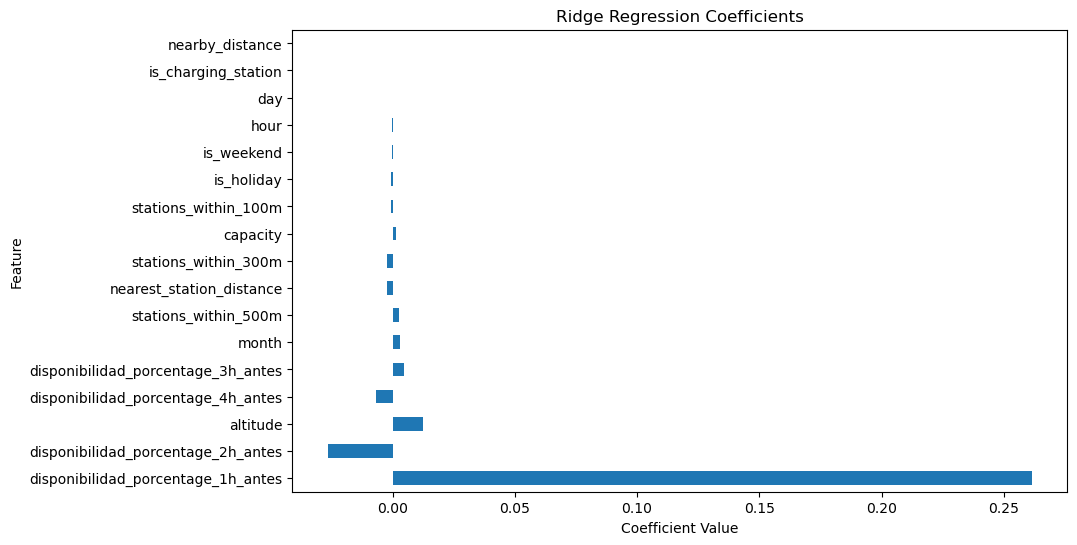

In [38]:
# Get the coefficients
coefficients = ridge_model.coef_

# Create a DataFrame to display the coefficients with feature names
coef_df = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Sort the coefficients by their absolute value (larger absolute values are more important)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print or visualize the most important coefficients
print(coef_df)

# Optionally, you can visualize the coefficients
import matplotlib.pyplot as plt
coef_df['Coefficient'].plot(kind='barh', figsize=(10, 6))
plt.title("Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

R-squared: 0.8250
Mean Squared Error: 0.0129


<Figure size 1000x800 with 0 Axes>

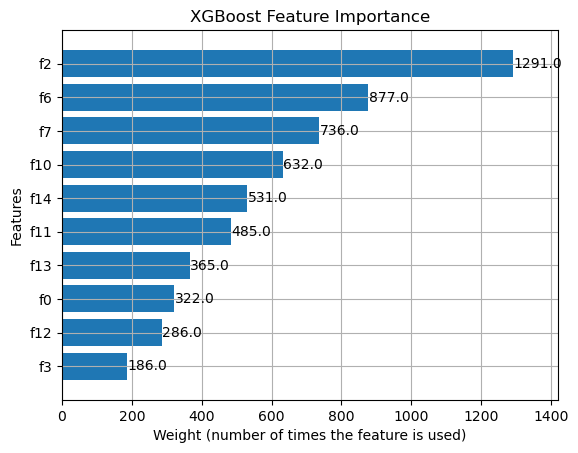

In [39]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes','altitude','special_event', 'cross_street_mod','Cross_barrio',
           'disponibilidad_porcentage_2h_antes', 
           'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 
            'stations_within_300m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for many ML algorithms, including XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using R-squared and Mean Squared Error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot feature importance with custom column names (feature names should be directly from the model)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()


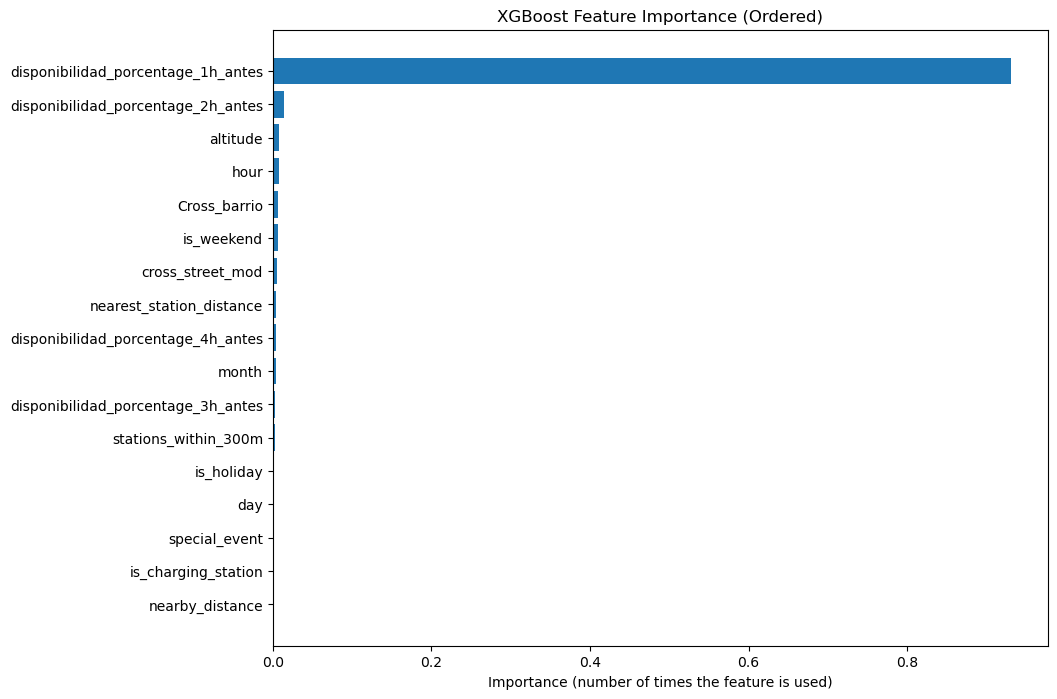

In [40]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for importances and corresponding feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances according to the order in 'features'
importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance in the same order as 'features'
plt.figure(figsize=(10, 8))

# Plot importance using 'weight' or another importance type
plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

Explained Variance Ratio of each component: [0.21730086 0.16825218 0.08365134 0.06255311 0.06119374 0.05582911
 0.05531153 0.0539793  0.05339498 0.04444619 0.04347763 0.03016168
 0.02124374 0.02069163 0.01758429 0.0062746  0.00329772 0.00135638]


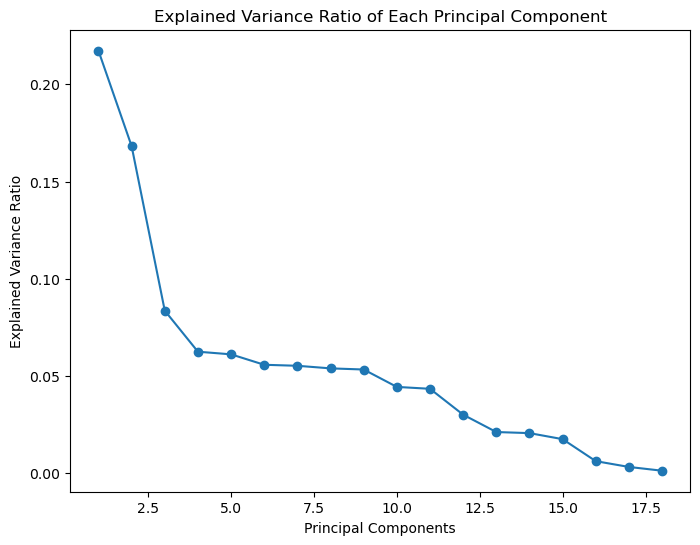

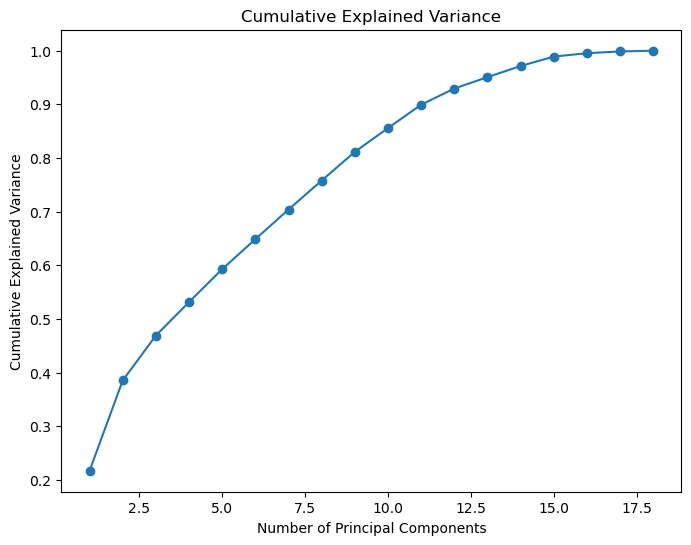

Number of components that explain 95% of the variance: 13


In [93]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features for PCA
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday','special_event','altitude', 'cross_street_mod','Cross_barrio',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']

# Prepare the data
X = df_prediction_task[features]

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Explained variance ratio to understand how much variance each component captures
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio of each component:", explained_variance)

# Step 4: Plot the explained variance to visualize the importance of each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Step 5: Cumulative Explained Variance (to decide how many components to retain)
cumulative_explained_variance = explained_variance.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Step 6: Choose the number of components based on cumulative explained variance (e.g., 95%)
n_components = 0
for i, variance in enumerate(cumulative_explained_variance):
    if variance >= 0.95:  # 95% explained variance
        n_components = i + 1
        break

print(f"Number of components that explain 95% of the variance: {n_components}")

# Step 7: Transform data to the selected number of principal components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# You can now use X_pca_reduced for modeling (e.g., XGBoost, Ridge regression, etc.)

In [94]:
# Example using XGBoost after PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the reduced PCA data
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.7779
Mean Squared Error: 0.0163


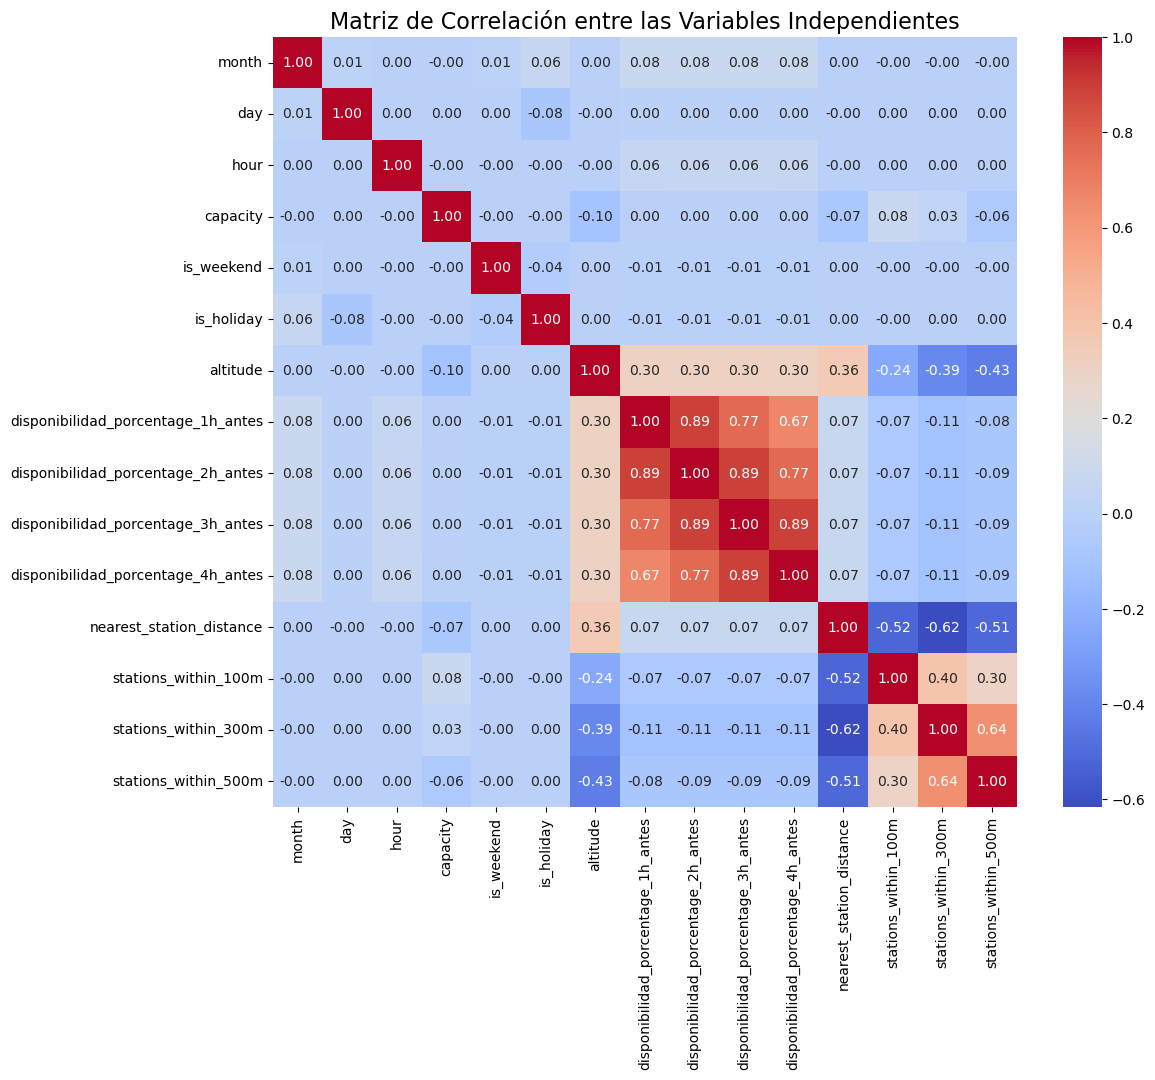

In [43]:
# 4. Correlación entre las variables independientes

features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday','altitude',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'stations_within_100m', 'cross_street_mod','Cross_barrio', 
            'stations_within_300m', 'stations_within_500m']

plt.figure(figsize=(12, 10))
corr_matrix = df_prediction_task[features].corr()  # Correlación entre las características
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')  #vmin=-1, vmax=1
plt.title('Matriz de Correlación entre las Variables Independientes', fontsize=16)
plt.savefig('correlation_matrix_plot.pdf', format='pdf', dpi=300)
plt.show()


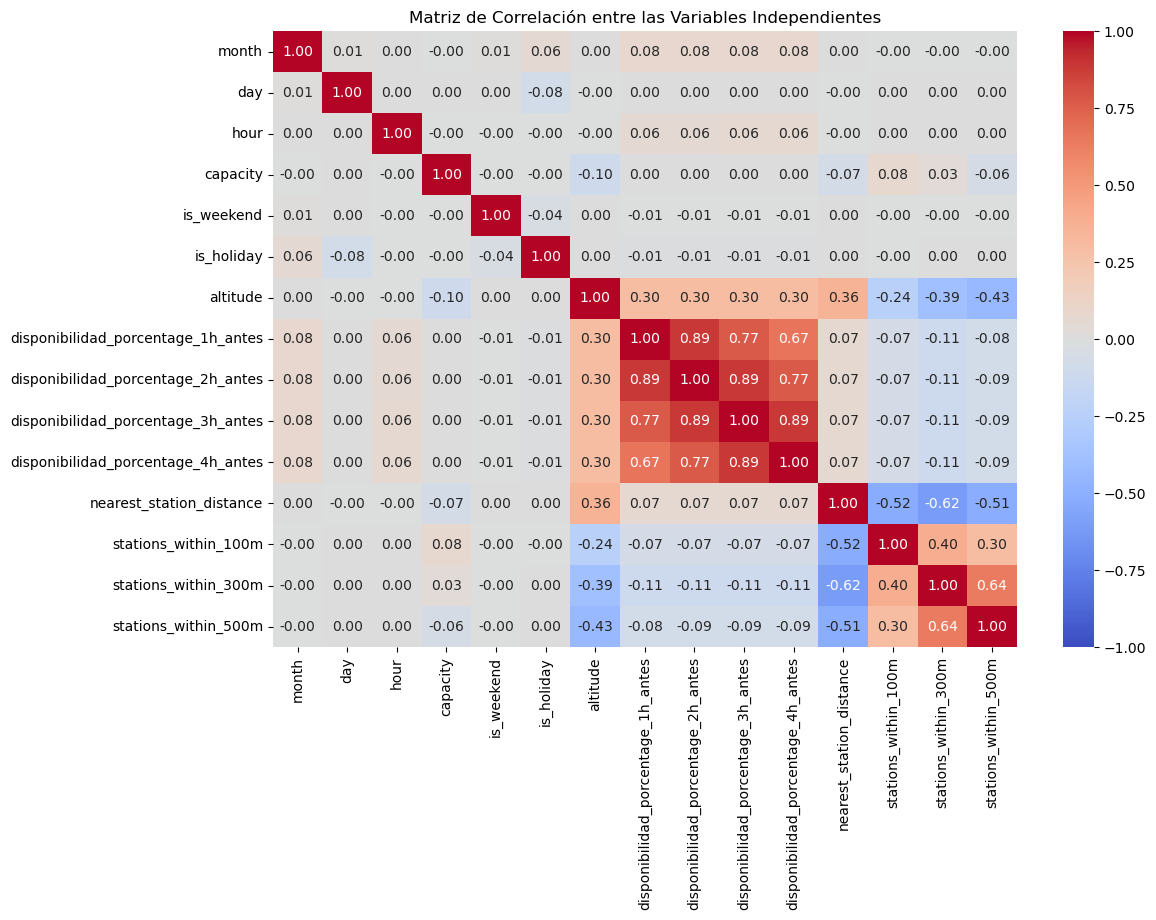

Correlation matrix plot saved as 'correlation_matrix_plot.png'


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_prediction_task[features].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Set the title
plt.title('Matriz de Correlación entre las Variables Independientes')

# Save the plot (ensure saving first, then show)
plt.savefig('correlation_matrix_plot.png', format='png', dpi=300)
plt.show()

print("Correlation matrix plot saved as 'correlation_matrix_plot.png'")

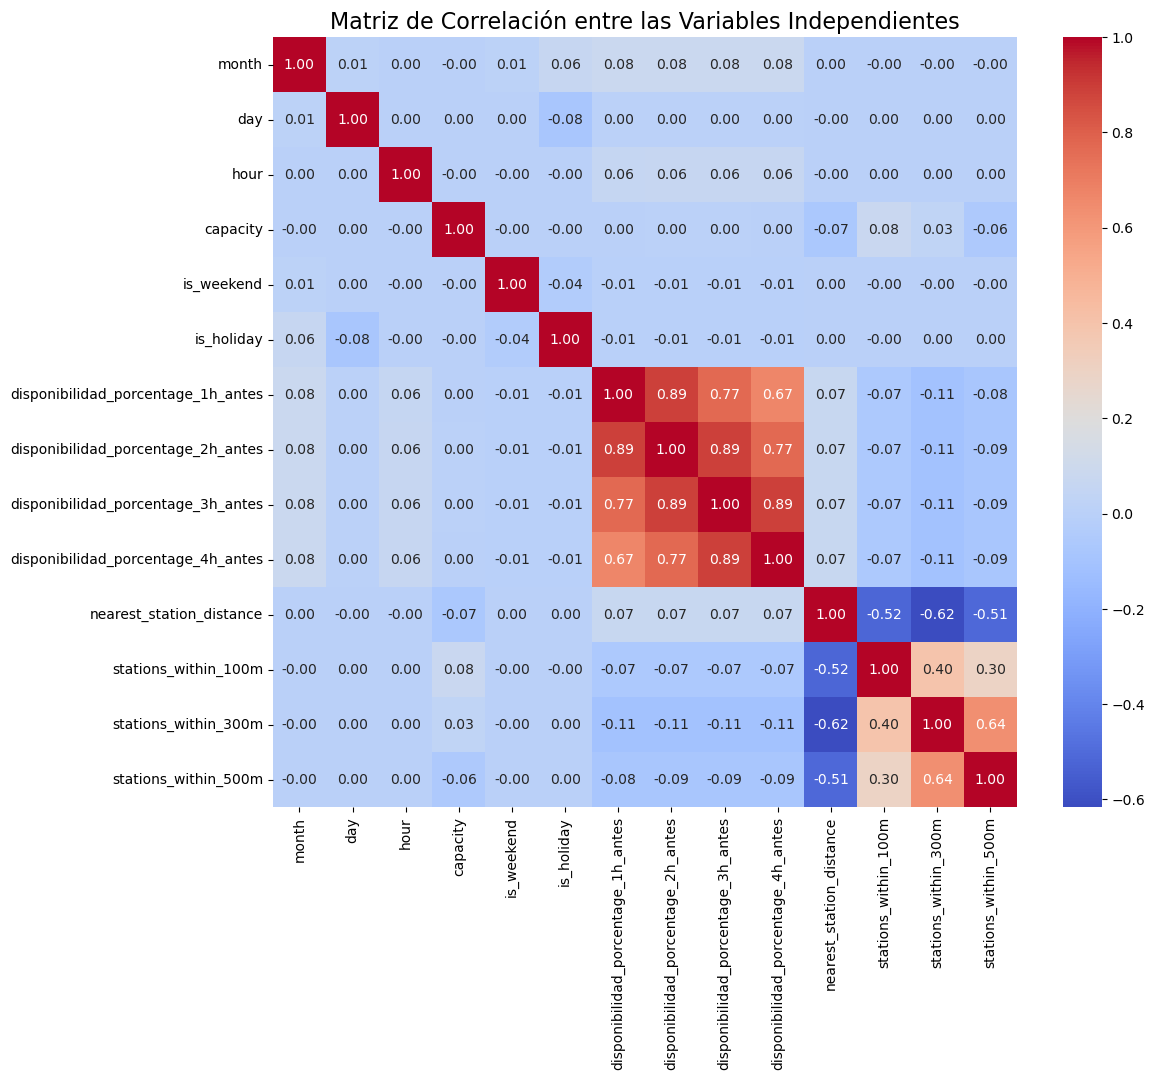

In [45]:
# 4. Correlación entre las variables independientes

features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 'cross_street_mod','Cross_barrio',
            'nearest_station_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']

plt.figure(figsize=(12, 10))
corr_matrix = df_prediction_task[features].corr()  # Correlación entre las características
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')  #vmin=-1, vmax=1
plt.title('Matriz de Correlación entre las Variables Independientes', fontsize=16)
plt.show()

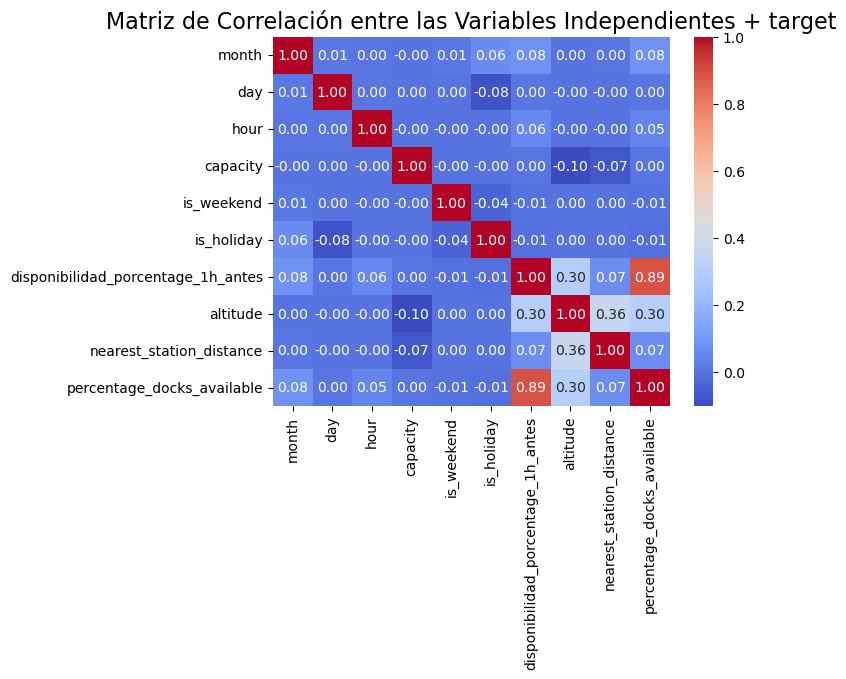

In [46]:
# 5. Correlación entre las variables independientes y la variable objetivo
# Correlación de las variables con el target

features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes', 'altitude',
            'nearest_station_distance']

corr_target = df_prediction_task[features + [target_variable]].corr()

sns.heatmap(corr_target, annot=True, cmap='coolwarm', fmt='.2f')  #vmin=-1, vmax=1
plt.title('Matriz de Correlación entre las Variables Independientes + target', fontsize=16)
plt.savefig('correlation_matrix_plot_con_target.png', format='png', dpi=300)
plt.show()

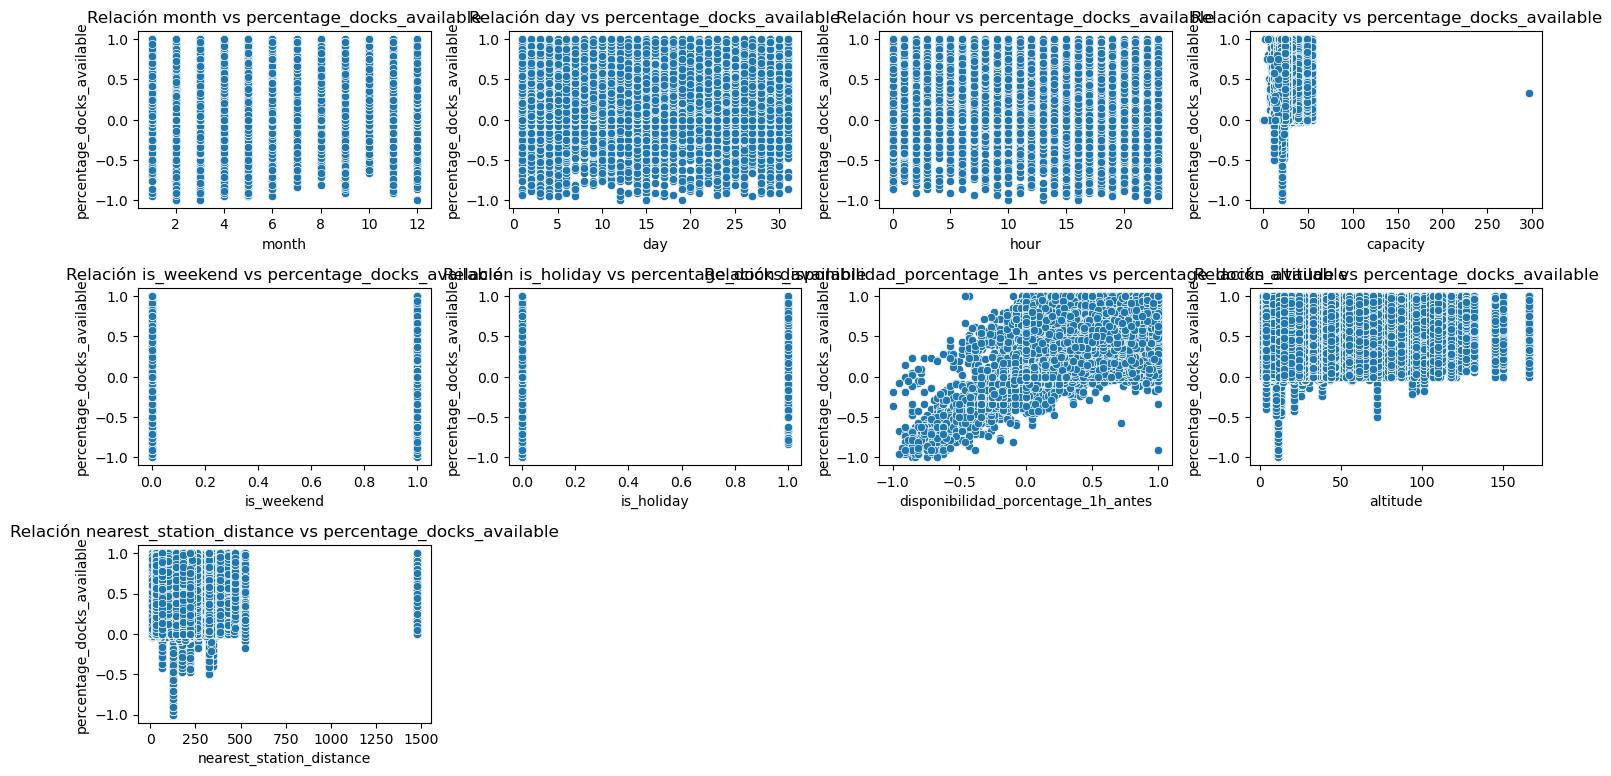

In [47]:
# 3. Relación entre las variables independientes y la variable objetivo
plt.figure(figsize=(15, 10))

# Graficar la relación de cada feature con el target
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(x=df_prediction_task[feature], y=df_prediction_task[target_variable])
    plt.title(f'Relación {feature} vs {target_variable}')
    plt.tight_layout()

plt.show()

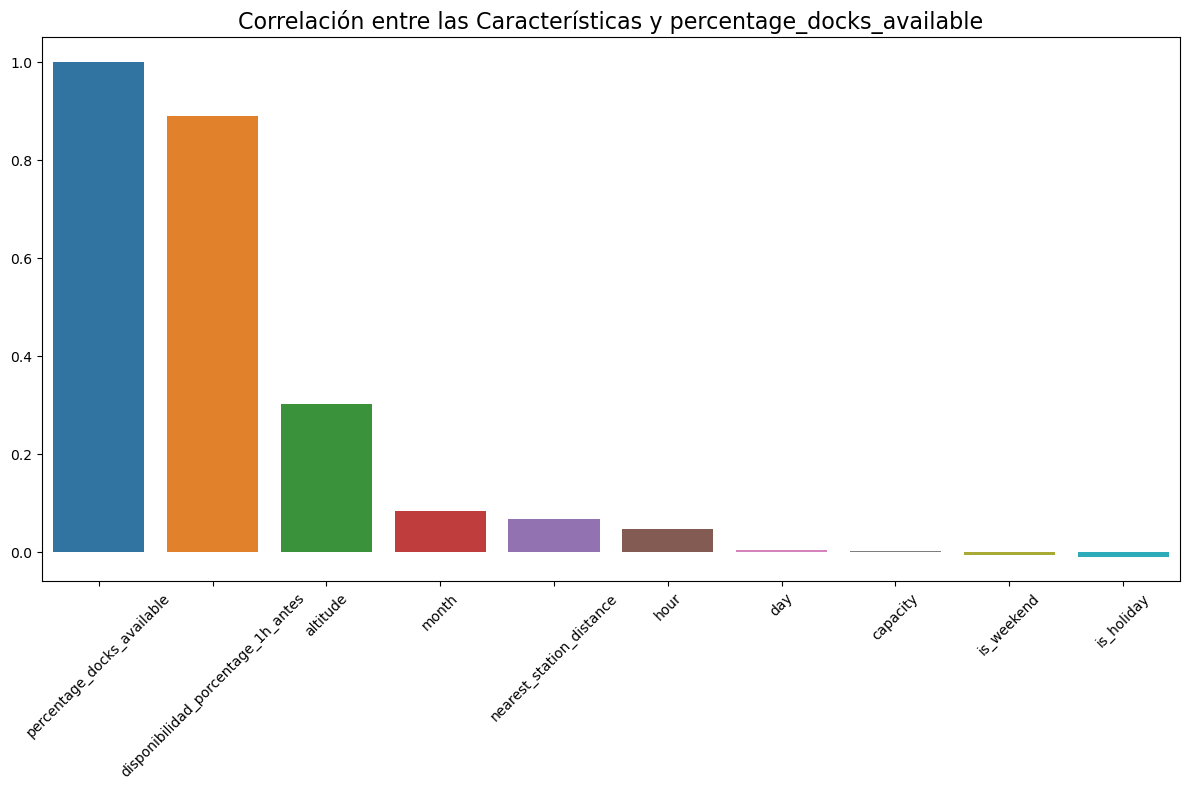

In [48]:
# 5. Correlación entre las variables independientes y la variable objetivo
# Correlación de las variables con el target
corr_target = df_prediction_task[features + [target_variable]].corr()

# Graficar la correlación con el target
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_target[target_variable].sort_values(ascending=False).index,
            y=corr_target[target_variable].sort_values(ascending=False).values)
plt.title(f'Correlación entre las Características y {target_variable}', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df_prediction_task['variable_interaction'] = pd.factorize(df_prediction_task['Cross_barrio'].astype(str) + '_' + df_prediction_task['post_code'].astype(str))[0]

Mean Squared Error: 0.012787500551976689
Root Mean Squared Error: 0.11308183121959375
R-squared: 0.8261485465566952


<Figure size 1000x800 with 0 Axes>

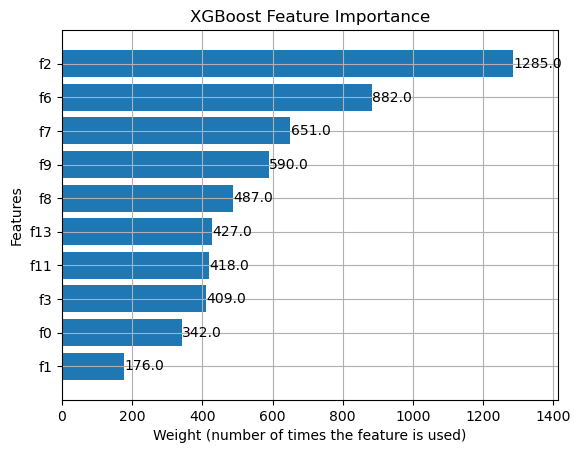

In [114]:
# Final model  


import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
# df_prediction_task = pd.read_csv('your_data.csv')  # If you're reading data from a file

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
           'disponibilidad_porcentage_1h_antes','altitude', 'post_code',
          'disponibilidad_porcentage_2h_antes','cross_street_mod','Cross_barrio','post_code',
            'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance_cap',
            'stations_within_300m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for many ML algorithms, including XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using R-squared and Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Plot feature importance with custom column names (feature names should be directly from the model)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()

In [115]:
# Convert y_pred to a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index, name='y_pred')

# Optional: Combine predictions with actual values for inspection
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_series
})
results_df

,y_true,y_pred
879384,0.8846,0.9053
671895,0.8519,0.8286
1307874,0.9259,0.9268
316458,0.8095,0.7491
938293,0.3333,0.3956
...,...,...
1925090,0.8636,0.8602
680290,0.1481,0.1695
1843640,0.8214,0.8163
1045154,0.4630,0.6365


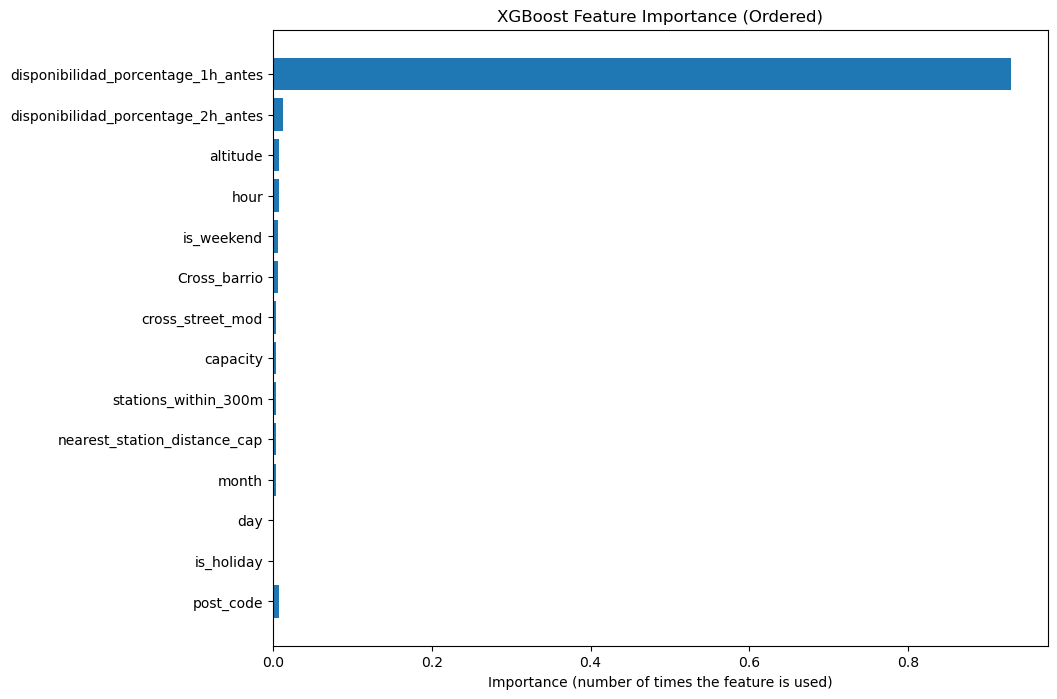

In [116]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for importances and corresponding feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances according to the order in 'features'
importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance in the same order as 'features'
plt.figure(figsize=(10, 8))

# Plot importance using 'weight' or another importance type
plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

100%|===================| 2075345/2075906 [25:42<00:00]        

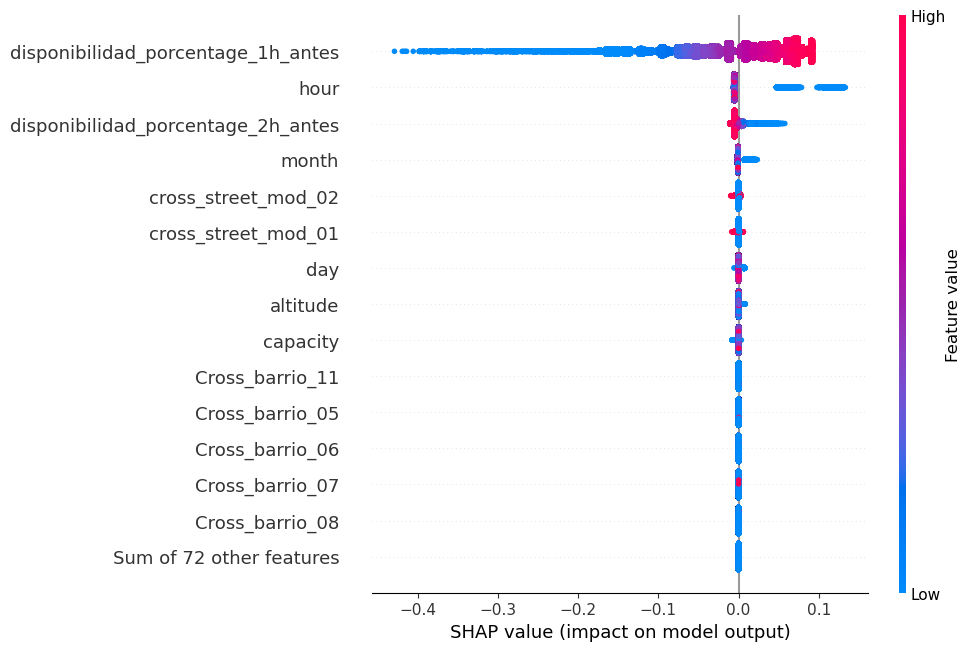

In [118]:
import shap
import matplotlib.pyplot as plt

X_encoded = pd.get_dummies(X, columns=['cross_street_mod', 'Cross_barrio'])

explainer = shap.Explainer(xgb_model, X_encoded)
shap_values = explainer(X_encoded)

shap.plots.beeswarm(shap_values, max_display=15, show=True)

In [ ]:
# SHAP Waterfall Chart
X_clean = pd.get_dummies(X)
explainer = shap.Explainer(xgb_model, X_clean)
shap_values = explainer(X_clean)
index = 1 

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[index])

 12%|==                  | 239833/2075906 [06:18<48:13]       

In [ ]:
########### LSTM ###########

In [53]:
import pandas as pd

# Seleccionar las columnas que usarás en el modelo
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
           'disponibilidad_porcentage_1h_antes','altitude',
          'disponibilidad_porcentage_2h_antes','cross_street_mod','Cross_barrio','post_code',
          'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance_cap',
            'stations_within_300m']

target = 'percentage_docks_available'

df = df_prediction_task[features + [target]].copy()

In [54]:
# Convertir variables categóricas en variables dummy (one-hot encoding)
df = pd.get_dummies(df, columns=['Cross_barrio', 'post_code', 'cross_street_mod'])

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
continuous_columns = ['capacity', 'disponibilidad_porcentage_1h_antes', 'altitude', 'disponibilidad_porcentage_2h_antes','disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes',
                      'nearest_station_distance_cap', 'stations_within_300m']

train_size = int(len(df) * 0.8)  # 80% para entrenamiento
train_df, test_df = df[:train_size], df[train_size:]

train_df[continuous_columns] = scaler.fit_transform(train_df[continuous_columns])
test_df[continuous_columns] = scaler.transform(test_df[continuous_columns])

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_43752/4159002485.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[continuous_columns] = scaler.fit_transform(train_df[continuous_columns])
/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_43752/4159002485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[continuous_columns] = scaler.transform(test_df[continuous_columns])


In [56]:
#train_size = int(len(df) * 0.8)  # 80% para entrenamiento
#train_df, test_df = df[:train_size], df[train_size:]

X_train = train_df.drop(target, axis=1)  # Características de entrenamiento
y_train = train_df[target]  # Variable objetivo de entrenamiento

X_test = test_df.drop(target, axis=1)  # Características de prueba
y_test = test_df[target]  # Variable objetivo de prueba
X_train = X_train.dropna()
y_train = y_train.dropna()
X_test=X_test.dropna()
y_test=y_test.dropna()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [57]:
# Convertir las entradas en 3D, ya que LSTM espera entradas con forma (samples, time_steps, features)
X_train = np.expand_dims(X_train, axis=1)  # (n_samples, 1, n_features)
X_test = np.expand_dims(X_test, axis=1)  # (n_samples, 1, n_features)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Crear el modelo LSTM
model = Sequential()

# Añadir la capa LSTM
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Añadir Dropout para regularización
model.add(Dropout(0.2))

# Capa densa de salida (predicción de la variable target)
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                49664     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49729 (194.25 KB)
Trainable params: 49729 (194.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
51898/51898 [==============================] - 37s 702us/step - loss: 0.0185 - val_loss: 0.0162
Epoch 2/10
51898/51898 [==============================] - 38s 733us/step - loss: 0.0162 - val_loss: 0.0153
Epoch 3/10
51898/51898 [==============================] - 43s 820us/step - loss: 0.0159 - val_loss: 0.0136
Epoch 4/10
51898/51898 [==============================] - 42s 817us/step - loss: 0.0158 - val_loss: 0.0133
Epoch 5/10
51898/51898 [==============================] - 39s 746us/step - loss: 0.0157 - val_loss: 0.0132
Epoch 6/10
51898/51898 [==============================] - 38s 737us/step - loss: 0.0156 - val_loss: 0.0133
Epoch 7/10
51898/51898 [==============================] - 41s 792us/step - loss: 0.0155 - val_loss: 0.0130
Epoch 8/10
51898/51898 [==============================] - 40s 769us/step - loss: 0.0155 - val_loss: 0.0138
Epoch 9/10
51898/51898 [==============================] - 43s 836us/step - loss: 0.0154 - val_loss: 0.0142
Epoch 10/10
51898/51898 [============

12975/12975 [==============================] - 5s 362us/step - loss: 0.0141
Test Loss: 0.014067314565181732
12975/12975 [==============================] - 4s 326us/step


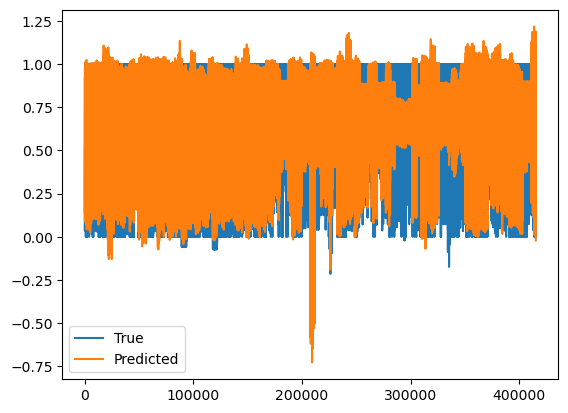

In [60]:
# Evaluar el modelo
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Hacer predicciones
y_pred = model.predict(X_test)

# Comparar las predicciones con los valores reales
import matplotlib.pyplot as plt
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [61]:
# Evaluate the model using R-squared and Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.014067352534767682
Root Mean Squared Error: 0.11860587057463759
R-squared: 0.7861828333650962


In [ ]:
################ LSTM SIMPLE ##################

In [62]:
import pandas as pd

# Seleccionar las columnas que usarás en el modelo
features_ = ['month', 'day', 'hour',
           'disponibilidad_porcentage_1h_antes',
          'disponibilidad_porcentage_2h_antes',
          'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes']

target = 'percentage_docks_available'

df_check = df_prediction_task[features_ + [target]].copy()

In [63]:
# Eliminar filas vacías
df_check = df_check.dropna(subset=features_ + [target])
df_check.drop_duplicates(inplace=True)

In [64]:
# Separar X e y
X = df_check[features_].values
y = df_check[[target]].values

# Split train/test
split = int(len(X) * 0.8)
X_raw_train, X_raw_test = X[:split], X[split:]
y_raw_train, y_raw_test = y[:split], y[split:]

# Escalar
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_raw_train)
X_test_scaled = scaler_X.transform(X_raw_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_raw_train)
y_test_scaled = scaler_y.transform(y_raw_test)

# Reshape para LSTM
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], len(features_), 1))
X_test = X_test_scaled.reshape((X_test_scaled.shape[0], len(features_), 1))

In [65]:
# Modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# Entrenar
model.fit(X_train, y_train_scaled, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
92660/92660 [==============================] - 88s 951us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 2/10
92660/92660 [==============================] - 89s 956us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 3/10
92660/92660 [==============================] - 86s 928us/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/10
92660/92660 [==============================] - 85s 921us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/10
92660/92660 [==============================] - 86s 923us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/10
92660/92660 [==============================] - 86s 923us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/10
92660/92660 [==============================] - 86s 923us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 8/10
92660/92660 [==============================] - 86s 925us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
92660/92660 [==============================] - 86s 925us/step - loss: 0.0038 - val_loss: 0.0035
Epoch 10/10
92660/92660 [============

In [67]:
# Predecir
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Evaluar
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

12870/12870 [==============================] - 5s 420us/step
MSE: 0.0115
R²: 0.8259


In [68]:
# Evaluate the model using R-squared and Mean Squared Error
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test_actual, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.011455619687143101
Root Mean Squared Error: 0.10703092864748535
R-squared: 0.8259023673588896


In [ ]:
############### LSTM ALIMENTADA ##################

In [99]:
# Features
sequence_features = [
    'disponibilidad_porcentage_4h_antes',
    'disponibilidad_porcentage_3h_antes',
    'disponibilidad_porcentage_2h_antes',
    'disponibilidad_porcentage_1h_antes'
]
context_features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 
                    'is_holiday','altitude', 'post_code','cross_street_mod',
                    'Cross_barrio','post_code', 'nearest_station_distance_cap', 'stations_within_300m']
target = 'percentage_docks_available'

In [100]:
df_new = df_prediction_task[sequence_features + context_features + [target]].copy()

In [104]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate


# Separar X e y
X_seq = df_new[sequence_features].values
X_ctx = df_new[context_features].values
y = df_new[[target]].values


'''
X_seq_train = df_new[sequence_features].values
X_ctx_train = df_new[context_features].values

X_seq_test = df_test_new[sequence_features].values
X_ctx_test = df_test_new[context_features].values

y_train = df_new[[target]].values
'''


# Split train/test
split = int(len(df) * 0.8)
X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
X_ctx_train, X_ctx_test = X_ctx[:split], X_ctx[split:]
y_train, y_test = y[:split], y[split:]

# Escalar
scaler_seq = MinMaxScaler()
scaler_ctx = MinMaxScaler()
scaler_y = MinMaxScaler()

X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train).reshape((-1, 4, 1))
X_seq_test_scaled = scaler_seq.transform(X_seq_test).reshape((-1, 4, 1))

X_ctx_train_scaled = scaler_ctx.fit_transform(X_ctx_train)
X_ctx_test_scaled = scaler_ctx.transform(X_ctx_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Modelo
input_seq = Input(shape=(4, 1), name="secuencia")
lstm_out = LSTM(50, activation='relu')(input_seq)

input_ctx = Input(shape=(X_ctx_train_scaled.shape[1],), name="contexto")

merged = Concatenate()([lstm_out, input_ctx])
output = Dense(1)(merged)

model = Model(inputs=[input_seq, input_ctx], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [105]:
# Entrenamiento
model.fit(
    {'secuencia': X_seq_train_scaled, 'contexto': X_ctx_train_scaled},
    y_train_scaled,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
93416/93416 [==============================] - 67s 717us/step - loss: 0.0047 - val_loss: 0.0036
Epoch 2/10
93416/93416 [==============================] - 72s 770us/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/10
93416/93416 [==============================] - 73s 785us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/10
93416/93416 [==============================] - 76s 815us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/10
93416/93416 [==============================] - 82s 877us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 6/10
93416/93416 [==============================] - 80s 856us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 7/10
93416/93416 [==============================] - 79s 847us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/10
93416/93416 [==============================] - 79s 848us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/10
93416/93416 [==============================] - 79s 841us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 10/10
93416/93416 [============

In [106]:
# Predicción y evaluación
y_pred_scaled = model.predict({'secuencia': X_seq_test_scaled, 'contexto': X_ctx_test_scaled})
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

print("MSE:", mean_squared_error(y_test_actual, y_pred))
print("R²:", r2_score(y_test_actual, y_pred))

12975/12975 [==============================] - 5s 355us/step
MSE: 0.011453109420736051
R²: 0.8259181036766596


In [107]:
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test_actual, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.011453109420736051
Root Mean Squared Error: 0.10701920117780758
R-squared: 0.8259181036766596


In [69]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [70]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [71]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [72]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'cross_street_mod',
       'Cross_barrio', 'nearest_station_distance_cap', 'Date', 'special_event',
       'is_weekend', 'is_holiday', 'variable_interaction'],
      dtype='object')

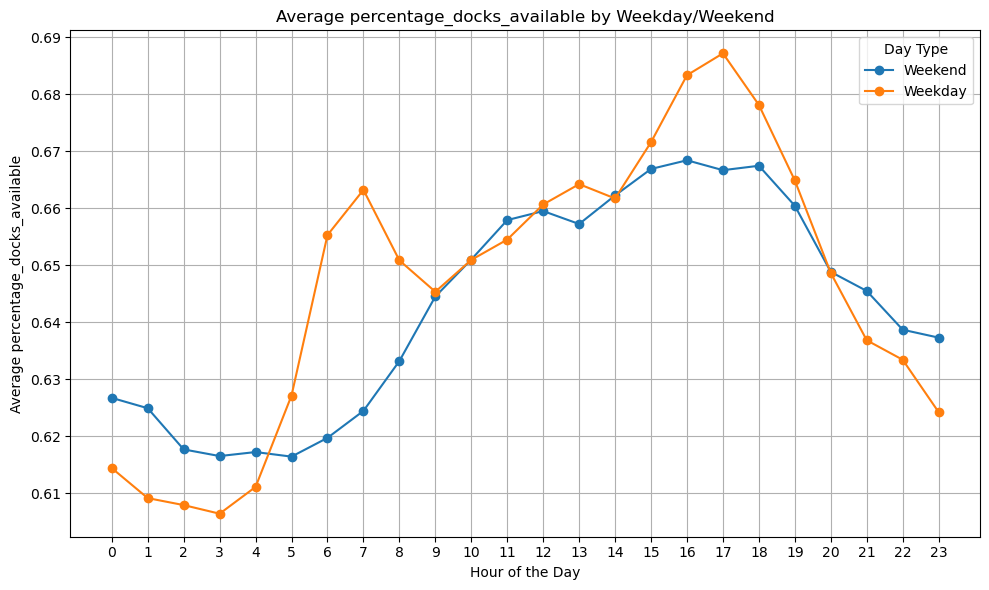

In [73]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'is_weekend'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_weekend'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Weekend' if weekday else 'Weekday', marker='o')

plt.title('Average percentage_docks_available by Weekday/Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

In [89]:
df_prediction_task['post_code'].max()

8930.0

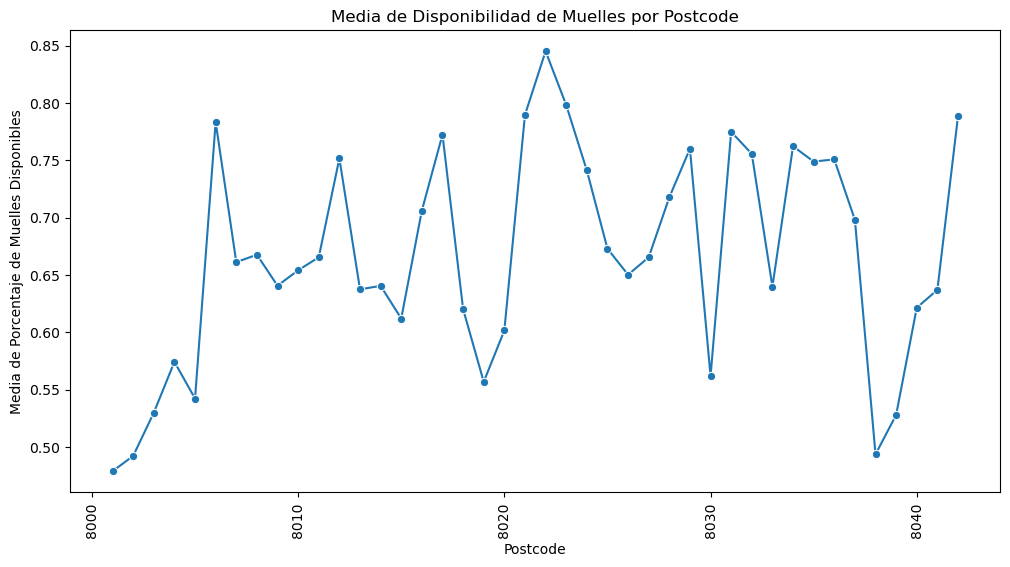

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por código postal y calcular la media de 'percentage_docks_available'
df_grouped = df_prediction_task[df_prediction_task['post_code']!=8930.0].groupby('post_code')['percentage_docks_available'].mean().reset_index()

# Crear gráfica de línea
plt.figure(figsize=(12, 6))
sns.lineplot(x='post_code', y='percentage_docks_available', data=df_grouped, marker='o')

# Mejorar visualización
plt.xticks(rotation=90)  # Rotar etiquetas del eje x si hay muchos códigos postales
plt.title('Media de Disponibilidad de Muelles por Postcode')
plt.xlabel('Postcode')
plt.ylabel('Media de Porcentaje de Muelles Disponibles')
plt.show()


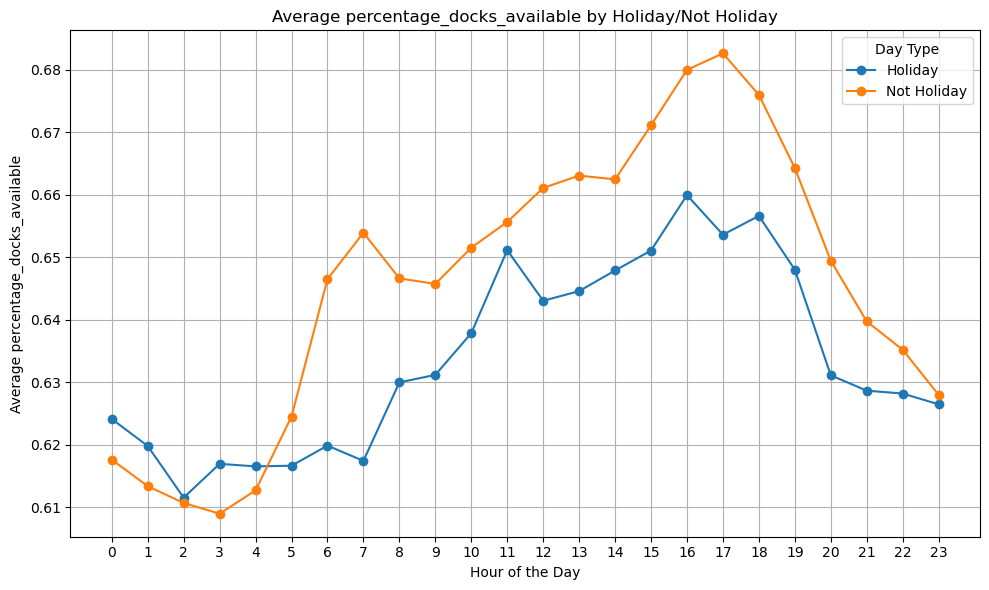

In [75]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'is_holiday'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_holiday'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Holiday' if weekday else 'Not Holiday', marker='o')

plt.title('Average percentage_docks_available by Holiday/Not Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

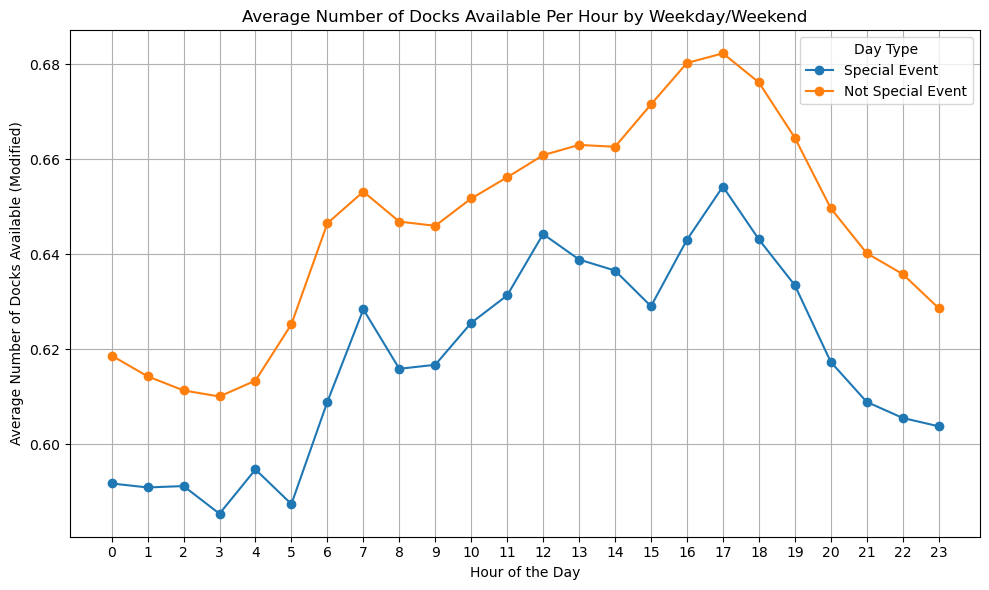

In [76]:
# Group the data by 'hour' and 'is_weekday' to calculate the average number of docks available per hour
hourly_docks = df_prediction_task.groupby(['hour', 'special_event'])['percentage_docks_available'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['special_event'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Special Event' if weekday else 'Not Special Event', marker='o')

plt.title('Average Number of Docks Available Per Hour by Weekday/Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Docks Available (Modified)')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))  # Show hours 0-23 on the x-axis
plt.tight_layout()
plt.show()

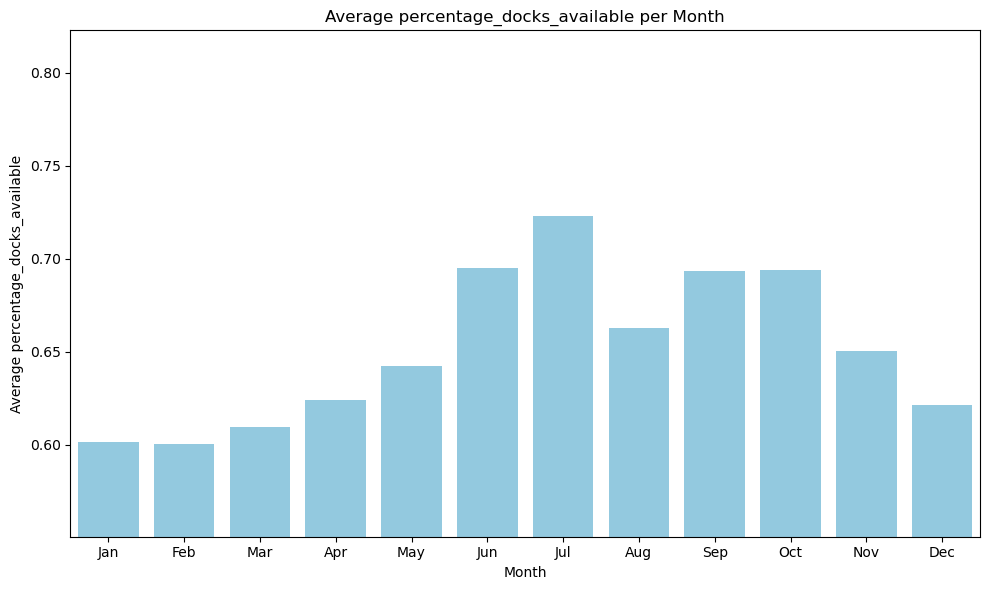

In [77]:
# Group by 'month' and calculate the average number of docks available (modified) for each month
monthly_avg_docks = df_prediction_task.groupby('month')['percentage_docks_available'].mean().reset_index()

# Plotting the results as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_avg_docks, x='month', y='percentage_docks_available', color='skyblue')
plt.ylim(monthly_avg_docks['percentage_docks_available'].min() - 0.05, monthly_avg_docks['percentage_docks_available'].max() + 0.1)
# Labels and title
plt.title('Average percentage_docks_available per Month')
plt.xlabel('Month')
plt.ylabel('Average percentage_docks_available')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()

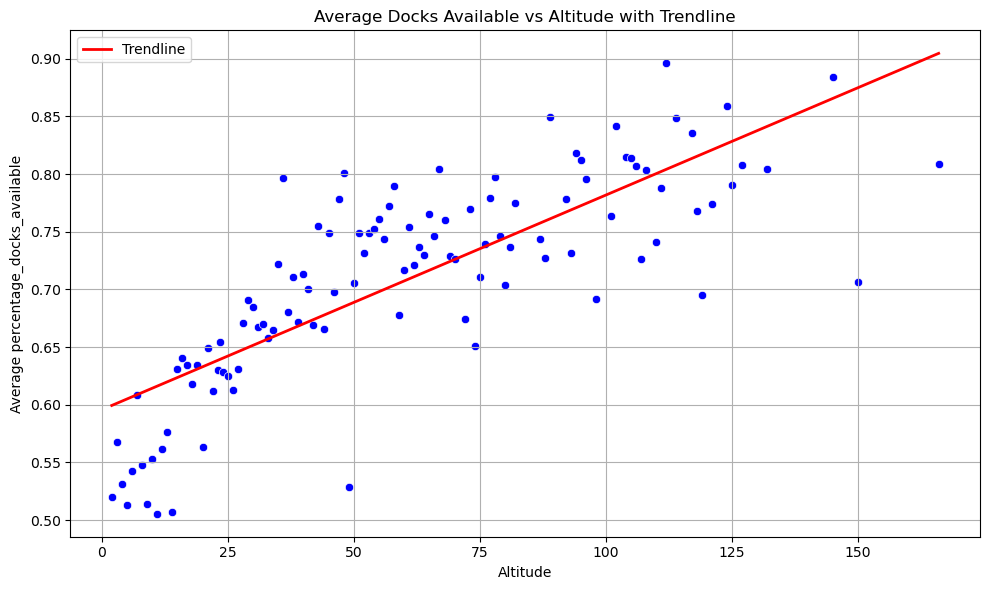

In [78]:
# Calculate the average number of docks available per altitude
altitude_avg_docks = df_prediction_task.groupby('altitude')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=altitude_avg_docks, x='altitude', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = altitude_avg_docks[['altitude']]  # Independent variable (altitude)
y = altitude_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(altitude_avg_docks['altitude'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average Docks Available vs Altitude with Trendline')
plt.xlabel('Altitude')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

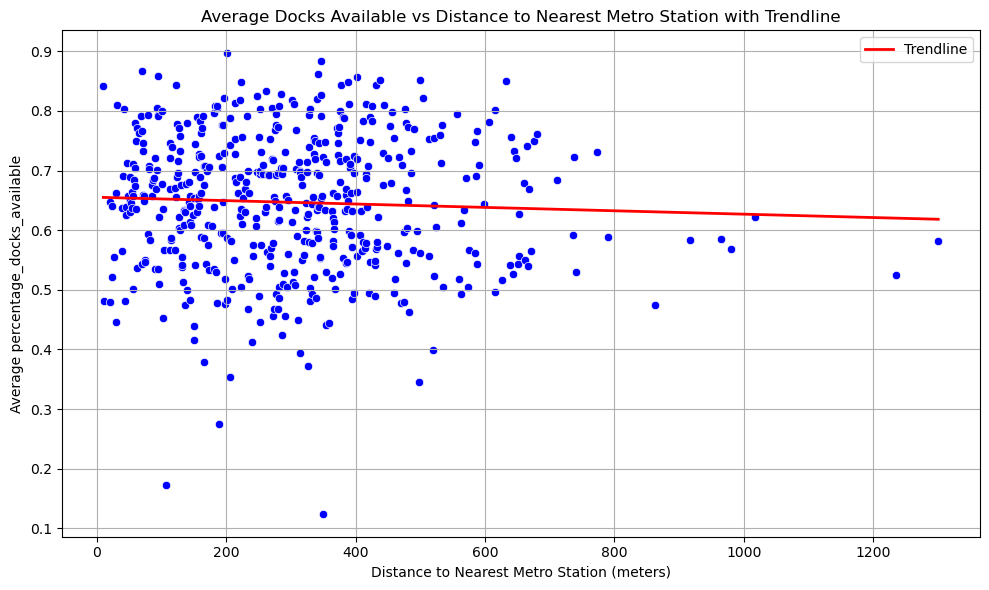

In [79]:
# Calculate the average number of docks available per distance to nearest metro station
distance_avg_docks = df_prediction_task.groupby('distance_to_nearest_metro')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=distance_avg_docks, x='distance_to_nearest_metro', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = distance_avg_docks[['distance_to_nearest_metro']]  # Independent variable (distance to metro)
y = distance_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(distance_avg_docks['distance_to_nearest_metro'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average Docks Available vs Distance to Nearest Metro Station with Trendline')
plt.xlabel('Distance to Nearest Metro Station (meters)')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

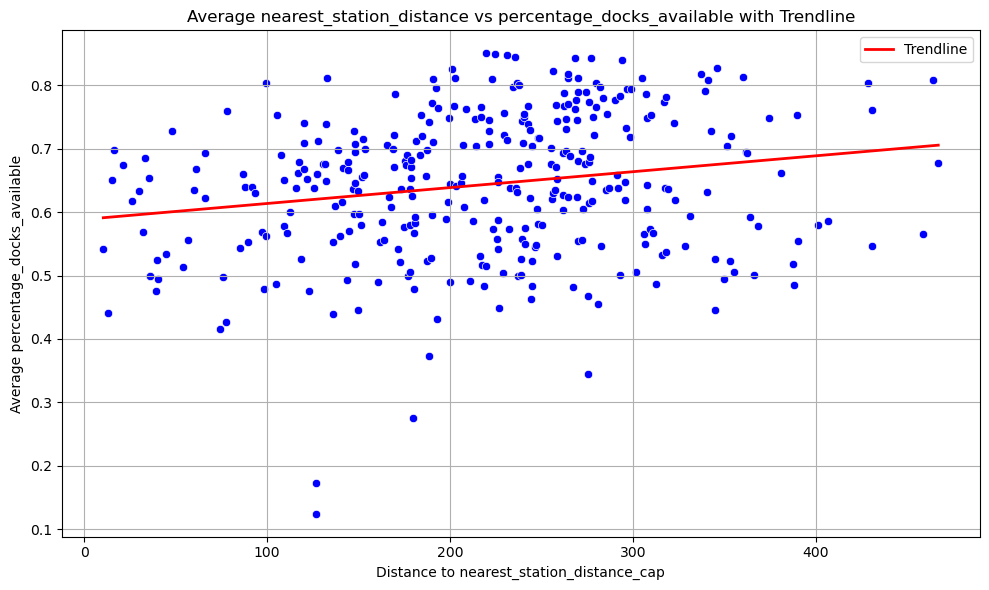

In [80]:
# Calculate the average number of docks available per distance to nearest metro station
distance_avg_docks = df_prediction_task.groupby('nearest_station_distance_cap')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=distance_avg_docks, x='nearest_station_distance_cap', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = distance_avg_docks[['nearest_station_distance_cap']]  # Independent variable (distance to metro)
y = distance_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(distance_avg_docks['nearest_station_distance_cap'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average nearest_station_distance vs percentage_docks_available with Trendline')
plt.xlabel('Distance to nearest_station_distance_cap')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

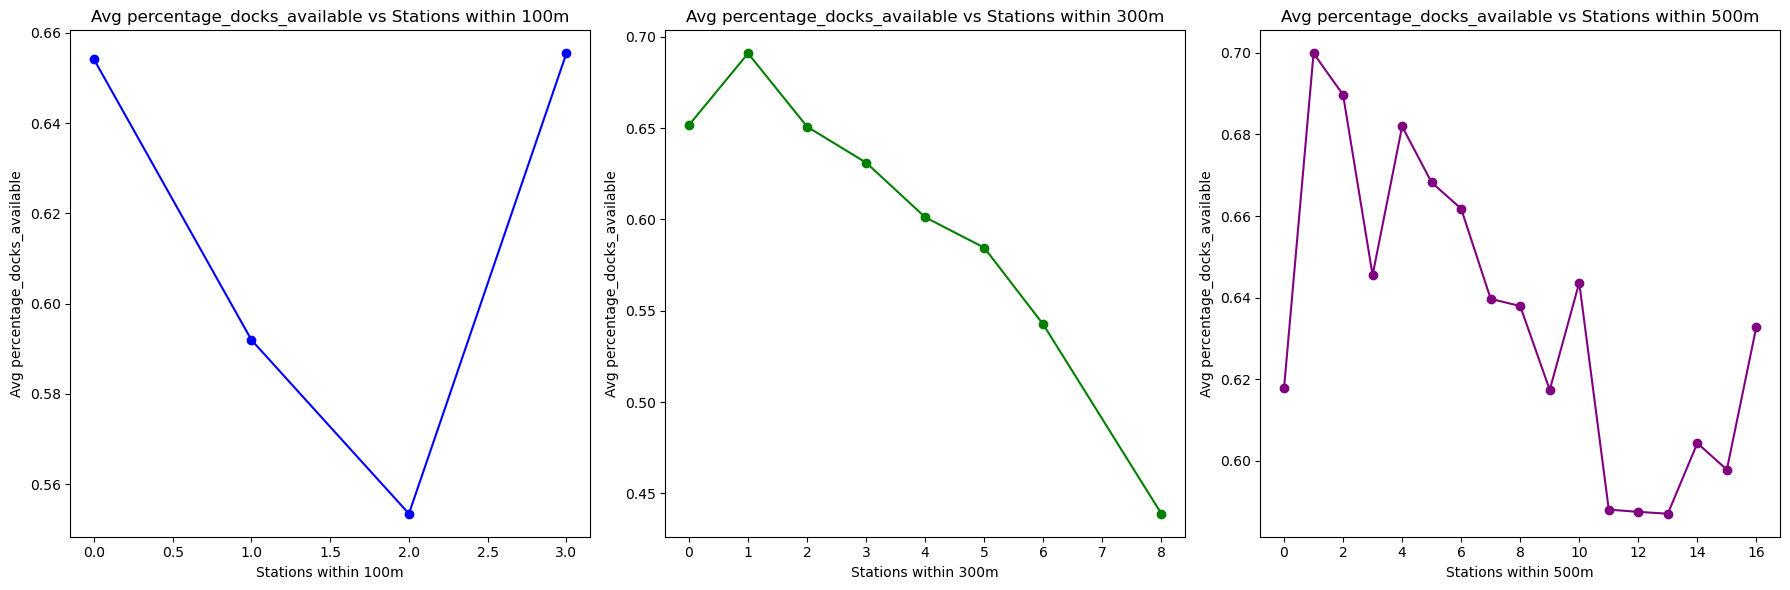

In [81]:
stations_within_100m_avg = df_prediction_task.groupby('stations_within_100m')['percentage_docks_available'].mean().reset_index()
stations_within_300m_avg = df_prediction_task.groupby('stations_within_300m')['percentage_docks_available'].mean().reset_index()
stations_within_500m_avg = df_prediction_task.groupby('stations_within_500m')['percentage_docks_available'].mean().reset_index()

# Create a plot for each proximity measure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Line chart for stations within 100m
axes[0].plot(stations_within_100m_avg['stations_within_100m'], stations_within_100m_avg['percentage_docks_available'], marker='o', color='blue')
axes[0].set_title('Avg percentage_docks_available vs Stations within 100m')
axes[0].set_xlabel('Stations within 100m')
axes[0].set_ylabel('Avg percentage_docks_available')

# Line chart for stations within 300m
axes[1].plot(stations_within_300m_avg['stations_within_300m'], stations_within_300m_avg['percentage_docks_available'], marker='o', color='green')
axes[1].set_title('Avg percentage_docks_available vs Stations within 300m')
axes[1].set_xlabel('Stations within 300m')
axes[1].set_ylabel('Avg percentage_docks_available')

# Line chart for stations within 500m
axes[2].plot(stations_within_500m_avg['stations_within_500m'], stations_within_500m_avg['percentage_docks_available'], marker='o', color='purple')
axes[2].set_title('Avg percentage_docks_available vs Stations within 500m')
axes[2].set_xlabel('Stations within 500m')
axes[2].set_ylabel('Avg percentage_docks_available')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

In [82]:
n_stations = df_prediction_task.groupby(['stations_within_300m'])['station_id'].nunique().reset_index()
n_stations

,stations_within_300m,station_id
0,0,70
1,1,121
2,2,137
3,3,92
4,4,50
5,5,33
6,6,9
7,8,1


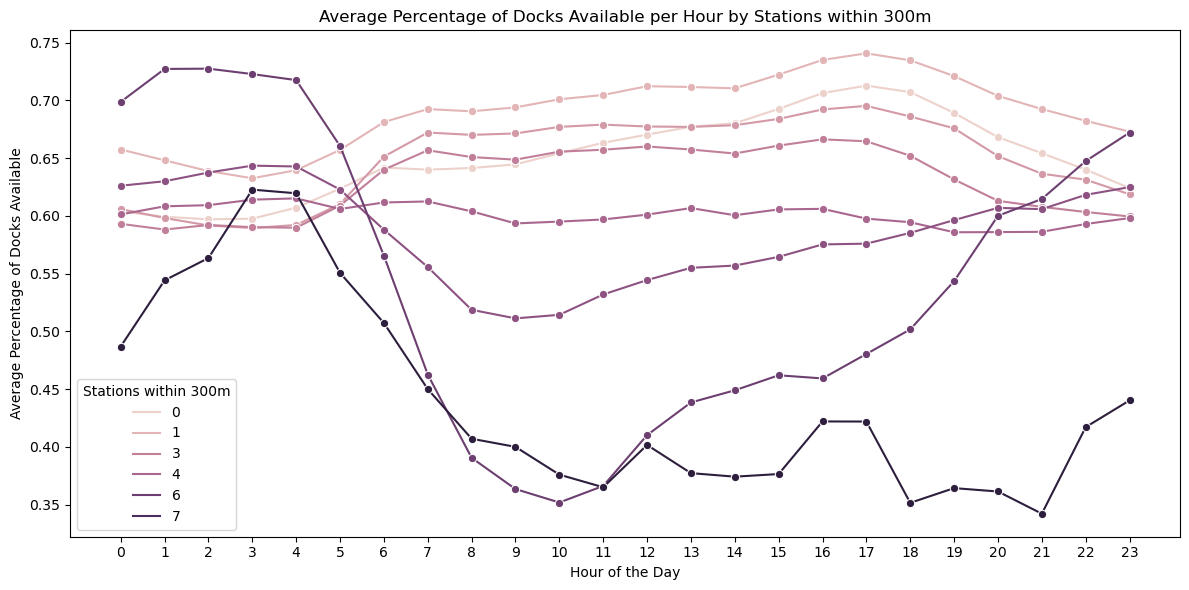

In [83]:
# Group by 'hour' and 'stations_within_300m' to calculate the average 'percentage_docks_available'
hourly_avg_docks = df_prediction_task.groupby(['hour', 'stations_within_300m'])['percentage_docks_available'].mean().reset_index()

# Plotting the results as a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg_docks, x='hour', y='percentage_docks_available', hue='stations_within_300m', marker='o')

# Labels and title
plt.title('Average Percentage of Docks Available per Hour by Stations within 300m')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Percentage of Docks Available')
plt.xticks(range(0, 24))  # Ensure hours are shown from 0 to 23
plt.legend(title='Stations within 300m')

# Show the plot
plt.tight_layout()
plt.show()


In [84]:
# Group by 'nearest_metro' and calculate the number of distinct station_id and the average number of docks available
metro_stats = df_prediction_task.groupby('nearest_metro').agg(
    num_distinct_stations=('station_id', 'nunique'),
    percentage_docks_available=('percentage_docks_available', 'mean')
).reset_index()

metro_stats_sorted = metro_stats.sort_values(by='num_distinct_stations', ascending=False)

# Get the top 10 and bottom 10 rows
top_10 = metro_stats_sorted.head(10)
bottom_10 = metro_stats_sorted.tail(10)

# Combine the top 10 and bottom 10 into one dataframe for easy display
final_df = pd.concat([top_10, bottom_10])

final_df.head(20)

,nearest_metro,num_distinct_stations,percentage_docks_available
15,Ciutadella | Vila Olímpica,25,0.5441
5,Barceloneta,15,0.4822
67,Poblenou,14,0.5314
20,Drassanes,11,0.4633
35,Hospital Clínic,10,0.7451
74,Sant Andreu,9,0.5936
45,Llacuna,8,0.6256
4,Barcelona - Arc de Triomf,8,0.6248
49,Maria Cristina,8,0.7263
59,Paral·lel,8,0.5255


In [85]:
# For top 10
top_10_avg = top_10[['num_distinct_stations', 'percentage_docks_available']].mean()

# For bottom 10
bottom_10_avg = bottom_10[['num_distinct_stations', 'percentage_docks_available']].mean()

# Combine both into a DataFrame for display
avg_df = pd.DataFrame({
    'Metric': ['Top 10 Average', 'Bottom 10 Average'],
    'Average Num Distinct Stations': [top_10_avg['num_distinct_stations'], bottom_10_avg['num_distinct_stations']],
    'Average percentage_docks_available': [top_10_avg['percentage_docks_available'], bottom_10_avg['percentage_docks_available']]
})

avg_df

,Metric,Average Num Distinct Stations,Average percentage_docks_available
0,Top 10 Average,11.6000,0.5862
1,Bottom 10 Average,1.0000,0.7187


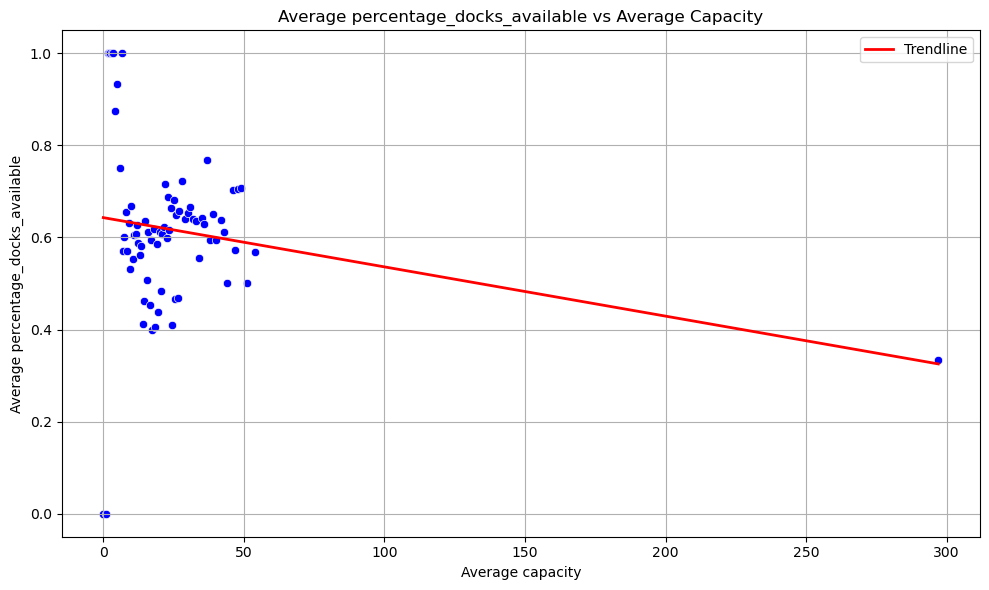

In [86]:
distance_avg_docks = df_prediction_task.groupby('capacity')['percentage_docks_available'].mean().reset_index()

# Scatter plot of the average values
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=distance_avg_docks, x='capacity', y='percentage_docks_available', color='blue')

# Fit a linear regression model to the data
X = distance_avg_docks[['capacity']]  # Independent variable (distance to metro)
y = distance_avg_docks['percentage_docks_available']  # Dependent variable (average docks available)
model = LinearRegression()
model.fit(X, y)

# Predict y values using the model
y_pred = model.predict(X)

# Plot the trendline
plt.plot(distance_avg_docks['capacity'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average percentage_docks_available vs Average Capacity')
plt.xlabel('Average capacity')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [87]:
df_prediction_task.groupby(['station_id', 'lat', 'lon'])['percentage_docks_available'].mean().reset_index().describe()

,station_id,lat,lon,percentage_docks_available
count,513.0000,513.0000,513.0000,513.0000
mean,263.0390,41.3995,2.1672,0.6429
std,150.5463,0.0211,0.0253,0.1205
min,1.0000,41.3468,2.1092,0.0000
25%,133.0000,41.3833,2.1476,0.5613
50%,264.0000,41.3955,2.1702,0.6514
75%,392.0000,41.4118,2.1867,0.7276
max,535.0000,41.4621,2.2207,0.8966


In [88]:
import folium
# Use your actual dataframe
df_map = df_prediction_task.groupby(['station_id', 'lat', 'lon'])['percentage_docks_available'].mean().reset_index()
df_map.dropna(inplace=True)

# Get central location to center the map
center_lat = df_map['lat'].mean()
center_lon = df_map['lon'].mean()

# Create map
bike_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Create color scale function
def color_availability(pct):
    if pct >= 0.75:
        return 'green'
    elif pct > 0.65:
        return 'orange'
    elif pct > 0.5:
        return 'red'
    else:
        return 'red'

# Add individual markers (no clustering)
for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=color_availability(row['percentage_docks_available']),
        fill=True,
        fill_opacity=0.7,
        popup=f"Station ID: {row['station_id']}<br>Availability: {row['percentage_docks_available']:.1f}%",
    ).add_to(bike_map)

# Show the map
bike_map